In [1]:
! /usr/bin/python3 -m pip install atlite
! /usr/bin/python3 -m pip install geopandas
! /usr/bin/python3 -m pip install seaborn
! /usr/bin/python3 -m pip install cartopy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [10]:
import atlite
import geopandas
import logging

logging.basicConfig(level=logging.INFO)

sweden = geopandas.read_file("data/geo/georef-sweden-kommun@public.geojson")

# Filter # Västra götalands län (14)
vgr_code = "14" 
vgr = sweden.loc[sweden.lan_code.apply(lambda x: vgr_code in x)]

# Simplify data with removing array (string[] => string)
vgr['kom_code'] = vgr['kom_code'].apply(lambda x: x[0])
vgr['kom_name'] = vgr['kom_name'].apply(lambda x: x[0])
vgr['lan_code'] = vgr['lan_code'].apply(lambda x: x[0])
vgr['lan_name'] = vgr['lan_name'].apply(lambda x: x[0])

vgr = vgr.assign(color='#283593')

minx = min(vgr.geometry.apply(lambda geom: geom.bounds[0]))
miny = min(vgr.geometry.apply(lambda geom: geom.bounds[1]))
maxx = max(vgr.geometry.apply(lambda geom: geom.bounds[2]))
maxy = max(vgr.geometry.apply(lambda geom: geom.bounds[3]))

print(f"Longitude (min/max) {minx} {maxx}")
print(f"Latitude  (min/max) {miny} {maxy}")

cutout = atlite.Cutout(
    path="vgr-test-kommun-00.nc",
    module="era5",
    x=slice(minx, maxx),
    y=slice(miny, maxy),
    time=slice("2011-01","2011-01"),
    dx=0.125,
    dy=0.125,
    dt="3h"
)

cutout.prepare()

INFO:atlite.data:Cutout already prepared.


Longitude (min/max) 10.592075916575439 14.778931341132603
Latitude  (min/max) 57.14551298876065 59.262765960857905


<Cutout "vgr-test-kommun-00">
 x = 10.62 ⟷ 14.75, dx = 0.12
 y = 57.25 ⟷ 59.25, dy = 0.12
 time = 2011-01-01 ⟷ 2011-01-31, dt = 3h
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [11]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter("ignore")
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

0    POLYGON ((10.56250 57.81250, 10.56250 57.93750...
dtype: geometry


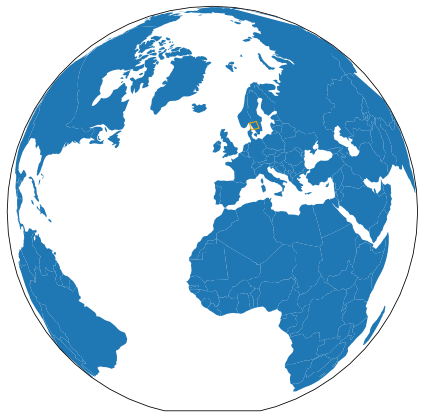

In [12]:
cells = cutout.grid
df = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country_bound = gpd.GeoSeries(cells.unary_union)

print(f"{str(country_bound)}")

projection = ccrs.Orthographic(-10, 35)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(6, 6))
df.plot(ax=ax, transform=plate())
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
fig.tight_layout()



In [13]:
shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shpreader.Reader(shpfilename)
UkIr = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
).reindex(["Sweden"])

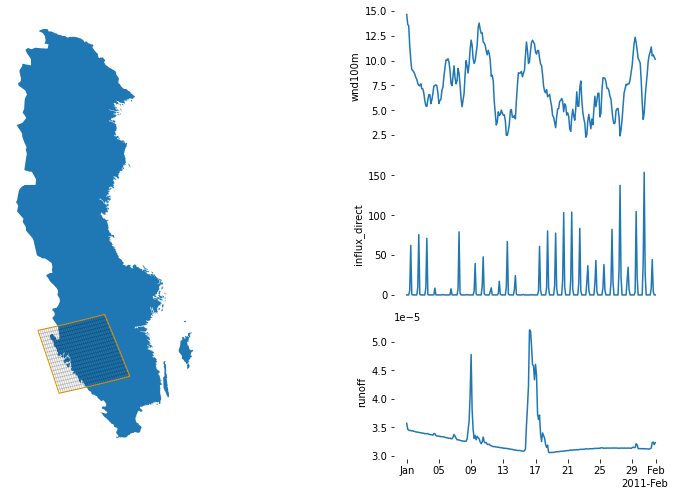

In [14]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
)
UkIr.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
ax.spines['geo'].set_edgecolor("white")

ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(["x", "y"]).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(["x", "y"]).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[2, 2], sharex=ax1)
cutout.data.runoff.mean(["x", "y"]).plot(ax=ax3)
ax3.set_frame_on(False)
ax3.set_xlabel(None)
fig.tight_layout()


INFO:atlite.convert:Convert and aggregate 'wind'.


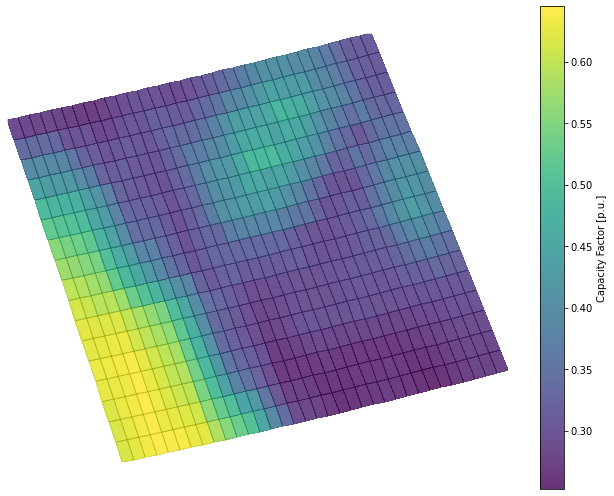

In [15]:
cap_factors = cutout.wind(turbine="Vestas_V112_3MW", capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(9, 7))
cap_factors.name = "Capacity Factor"
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
cells.plot(ax=ax, **plot_grid_dict)
ax.spines.geo.set_edgecolor("white")
fig.tight_layout();

In [16]:
import atlite
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

CORINE = "data/geo/corine.tif"
excluder = ExclusionContainer()
excluder.add_raster(CORINE, codes=range(20))

In [17]:
selected_kom_code = "1480" # Gbg

<AxesSubplot:>

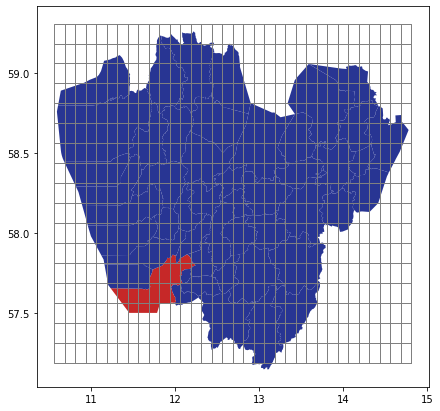

In [18]:
i = vgr.index[vgr['kom_code'] == selected_kom_code][0]
vgr['color'][i] = '#C62828'

plt.rc("figure", figsize=[10, 7])
fig, ax = plt.subplots()
vgr.plot(ax=ax,color=vgr['color']);
cutout.grid.plot(ax=ax, edgecolor="grey", color="None")

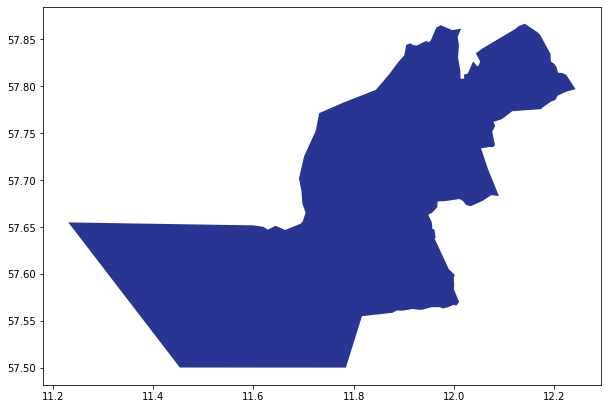

In [19]:
kom = vgr.loc[vgr.kom_code.apply(lambda x: selected_kom_code in x)]

kom.plot(figsize=(10, 7),color=vgr['color']);

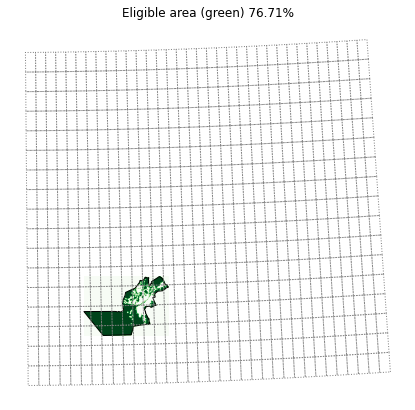

In [21]:
this_kom = kom.geometry.to_crs(excluder.crs)
masked, transform = excluder.compute_shape_availability(this_kom)

eligible_share = masked.sum() * excluder.res**2 / this_kom.geometry.item().area

fig, ax = plt.subplots()
excluder.plot_shape_availability(this_kom, ax=ax)
cutout.grid.to_crs(excluder.crs).plot(edgecolor="grey", color="None", ax=ax, ls=":")
ax.set_title(f"Eligible area (green) {eligible_share:.2%}")
ax.axis("off");

Compute availability matrix: 100%|████████| 1/1 [00:00<00:00, 13.27 gridcells/s]


<AxesSubplot:title={'center':'dim_0 = 28'}, xlabel='x', ylabel='y'>

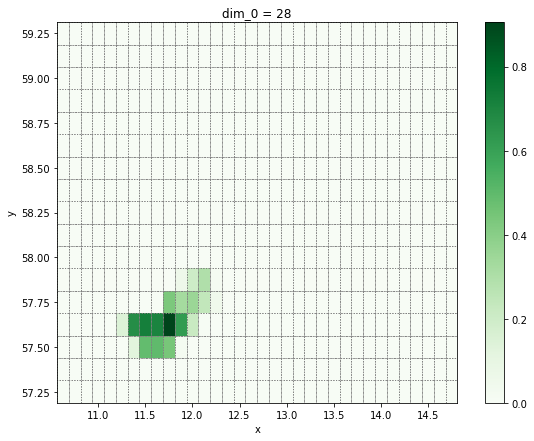

In [22]:
A = cutout.availabilitymatrix(this_kom, excluder)
#A

fig, ax = plt.subplots()
A.sel(dim_0=i).plot(cmap="Greens")
this_kom.plot(ax=ax, edgecolor="k", color="None")
cutout.grid.plot(ax=ax, color="None", edgecolor="grey", ls=":")
